<div>
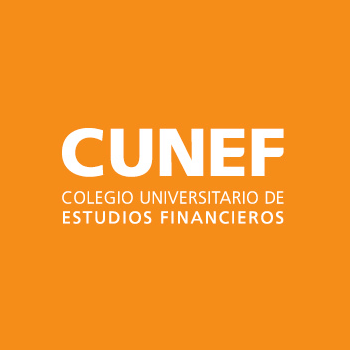
</div>

# **Petróleo (WTI)**

## *Librerías*

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV de los datos históricos del petróleo crudo (WTI)

- Fuente: https://es.finance.yahoo.com/quote/WTI/history?period1=1106870400&period2=1651968000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [8]:
df_wti = pd.read_csv("WTI.csv")
df_wti['Date'] = pd.to_datetime(df_wti['Date'])
df_wti = df_wti.set_index("Date")
df_wti

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-28,19.500000,19.799999,18.500000,18.500000,13.951934,9813500
2005-01-31,18.500000,18.590000,17.500000,18.200001,13.725693,1776800
2005-02-01,18.200001,18.400000,18.080000,18.209999,13.733230,656500
2005-02-02,18.250000,18.400000,18.190001,18.209999,13.733230,265300
2005-02-03,18.250000,18.350000,18.230000,18.250000,13.763398,303200
...,...,...,...,...,...,...
2022-05-02,4.700000,4.800000,4.430000,4.610000,4.610000,4947600
2022-05-03,4.600000,5.020000,4.600000,4.950000,4.950000,5740300
2022-05-04,5.090000,5.920000,5.090000,5.900000,5.900000,10682700


Los datos bursátiles que tenemos están a diario. Podríamos descargar el CSV con dichos datos de manera mensual, pero optaremos por hacer una conversión usando la función de remuestreo (resample) que ofrece la librería Pandas.
- Fuente de información: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [9]:
type(df_wti)

pandas.core.frame.DataFrame

In [10]:
ohlc_dict = {'Open':'first','High':'max','Low':'min','Close': 'last','Volume': 'sum'}
# explicación: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [11]:
df_wti = df_wti.resample('MS', closed='right', label='right').agg(ohlc_dict)
df_wti

,Open,High,Low,Close,Volume
Date,,,,,
2005-02-01,19.500000,19.799999,17.500000,18.209999,12246800
2005-03-01,18.250000,20.379999,18.049999,19.650000,6990300
2005-04-01,19.700001,22.250000,19.620001,20.780001,7006400
2005-05-01,21.100000,21.900000,19.490000,20.049999,4321600
2005-06-01,20.040001,22.150000,19.299999,21.690001,3875300
...,...,...,...,...,...
2022-02-01,3.260000,4.580000,3.240000,4.470000,53385000
2022-03-01,4.450000,5.270000,4.050000,5.110000,65433500
2022-04-01,5.250000,6.680000,3.800000,4.220000,154163100


## *Graficación de la serie temporal y análisis*

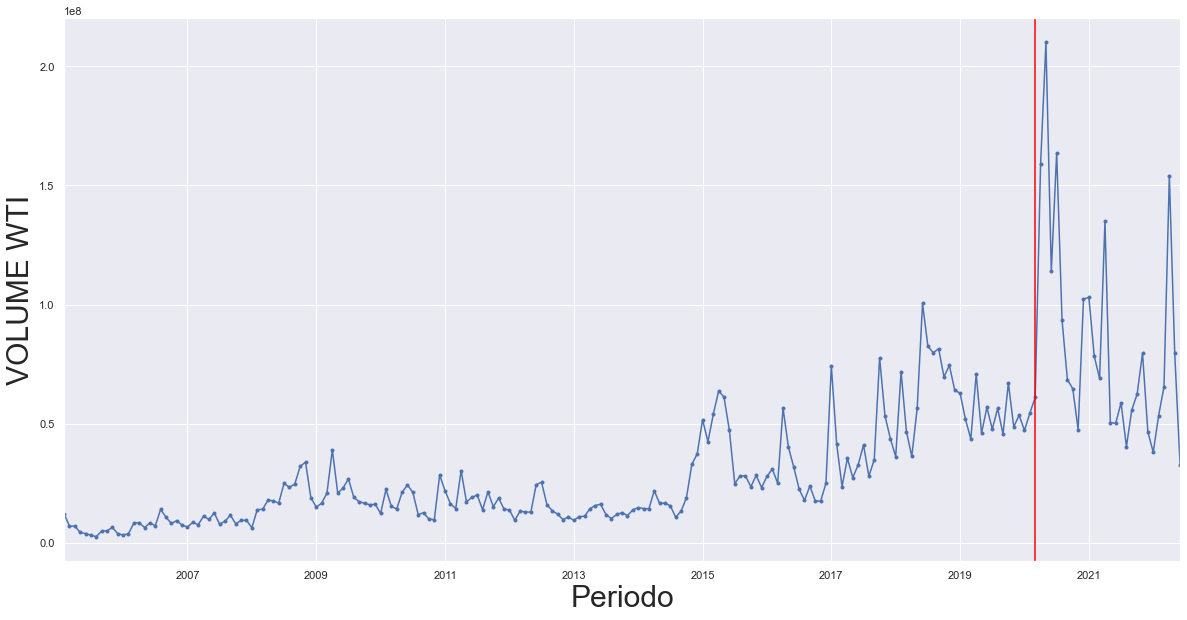

In [12]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_wti['Volume'].plot(marker='.') 
fig.set_ylabel('VOLUME WTI', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

Con el fin de ver mejor la gráfica de la serie temporal en un periodo más reciente, recortamos desde enero del 2014 en adelante:

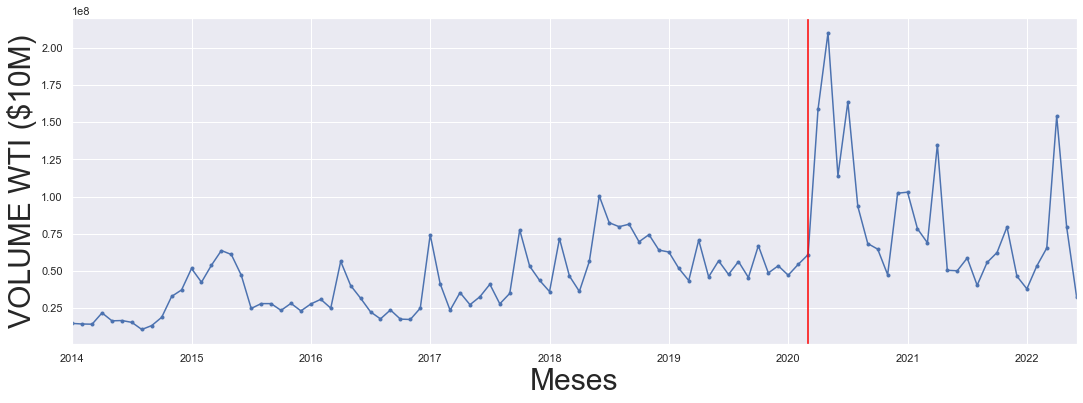

In [13]:
df_wti = df_wti.iloc[107:209]

sns.set(rc={'figure.figsize':(18, 6)})
fig = df_wti['Volume'].plot(marker='.') 
fig.set_ylabel('VOLUME WTI ($10M)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

En la gráfica podemos apreciar una tendencia creciente con ciertos micro-periodos de subidas-bajadas, y cuando inicia la pandemia por COVID-19 se inician una serie de subidas y bajadas muy pronunciadas generando mucho ruido en la gráfica. 

A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [14]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [15]:
mean = split_and_summarize(df_wti, 'Volume', 4, np.mean)

variance = split_and_summarize(df_wti, 'Volume', 4, np.var)

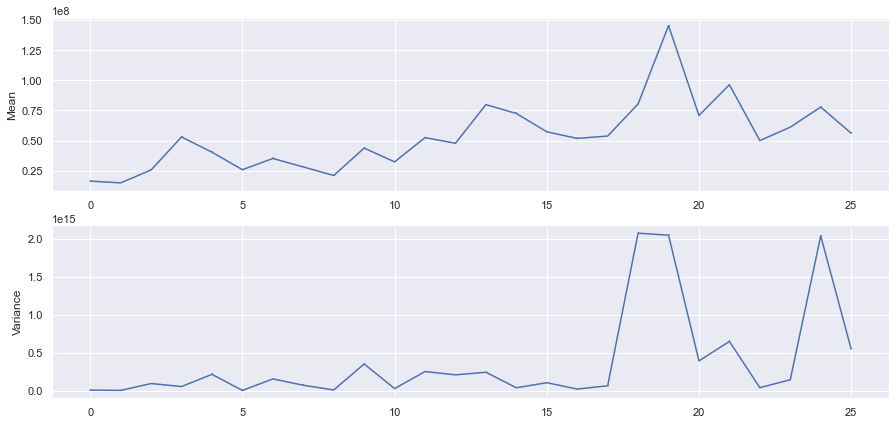

In [16]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()

Análisis de la estacionalidad y tendencia con distintas gráficas:

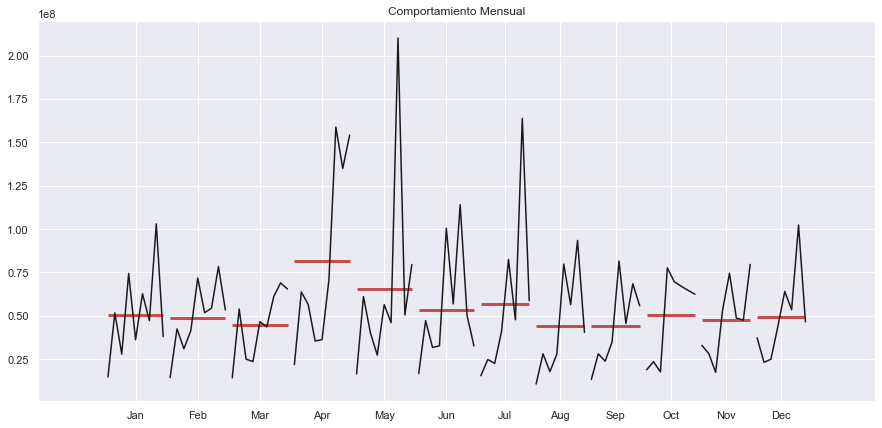

In [17]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_wti['Volume'], ax=ax)
ax.set_title('Comportamiento Mensual');

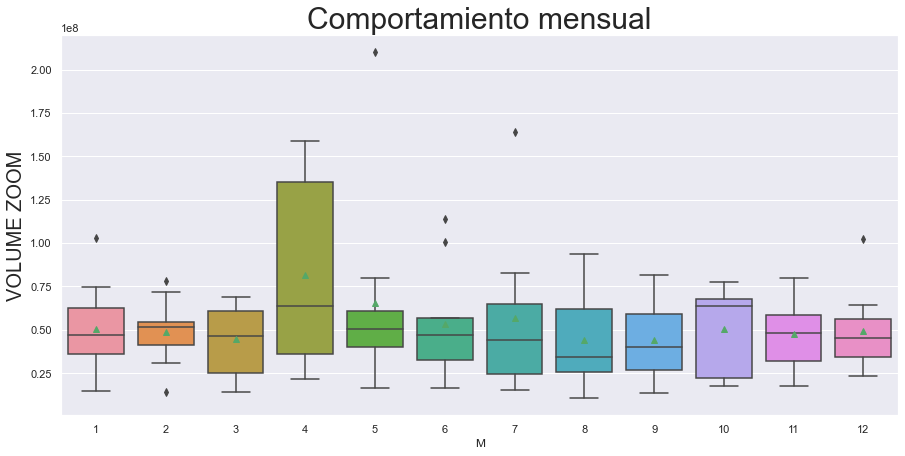

In [18]:
df_wti['M'] = df_wti.index.month
sns.boxplot(data = df_wti, x = 'M', y='Volume', showmeans=True)
ax = plt.gca()
ax.set_ylabel('VOLUME ZOOM', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Desglose de la estacionalidad, tendencia y residuos:

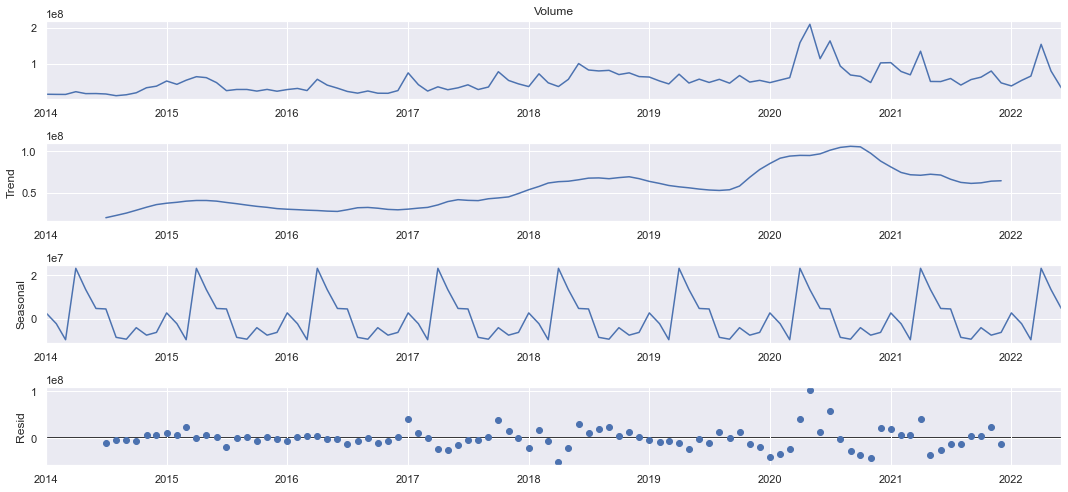

In [19]:
desglose = seasonal_decompose(df_wti['Volume'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Observamos que:
- Como dijimos antes, llevaba al principio tendencia creciente hasta la época COVID donde no se presenta una tendencia clara.
- No se aprecia estacionalidad ni tampoco es una serie estacionaria porque su media y varianza no son regulares a lo largo del periodo.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.
